In [1]:
import math
import numpy as np


class Gaussian:
    
    @classmethod
    def new_random(cls, mu_range, sigma_range):
        mu = np.random.uniform(mu_range[0], mu_range[1])
        sigma = np.random.uniform(sigma_range[0], sigma_range[1])
        return cls(mu, sigma)

    def __init__(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma
    
    def generate(self, n_obs: int = 1000):
        return np.random.normal(self.mu, self.sigma, size=(n_obs, ))

    def pdf(self, data: np.ndarray) -> np.ndarray:
        c = 1. / (self.sigma * math.sqrt(2 * math.pi))
        b = ((data - self.mu) ** 2) / (self.sigma ** 2)
        return c * np.exp(-0.5 * b)
    
    def __str__(self):
        return f"Gaussian(μ={round(self.mu, 3)}, σ={round(self.sigma, 3)})"


class Mixture:

    @classmethod
    def new_random(cls, mu1_range, sigma1_range, mu2_range, sigma2_range):
        normal1 = Gaussian.new_random(mu1_range, sigma1_range)
        normal2 = Gaussian.new_random(mu2_range, sigma2_range)
        pi = np.random.uniform(0.0, 1.0)
        return cls(normal1, normal2, pi)

    def __init__(self, normal1: Gaussian, normal2: Gaussian, pi: float):
        self.normal1 = normal1
        self.normal2 = normal2
        self.pi = pi
    
    def generate(self, n_obs: int = 1000):
        n1 = round(self.pi * n_obs)
        mix1 = self.normal1.generate(n1)
        mix2 = self.normal2.generate(n_obs - n1)
        return np.concatenate((mix1, mix2), axis=0)
        
    def pdf(self, data: np.ndarray) -> np.ndarray:
        mix1 = self.normal1.pdf(data)
        mix2 = self.normal2.pdf(data)
        return self.pi * mix1 + (1 - self.pi) * mix2
    
    def __str__(self):
        return f"Mixture: {self.normal1}, {self.normal2}, pi={round(self.pi, 3)}"

    def e_step(self, data: np.ndarray):
        r0 = self.pi * self.normal1.pdf(data)
        r1 = (1 - self.pi) * self.normal2.pdf(data)
        gamma = r0 / (r0 + r1)
        likelihood = np.sum(r0 + r1)
        return gamma, likelihood
    
    def m_step(self, data: np.ndarray, gamma0: np.ndarray):
        gamma1 = 1. - gamma0

        sum_gamma0 = np.sum(gamma0)
        sum_gamma1 = np.sum(gamma1)
        
        # Update pi
        self.pi = sum_gamma0 / n_obs
        
        # Update mu
        self.normal1.mu = new_mu0 = np.sum(gamma0 * data) / sum_gamma0
        self.normal2.mu = new_mu1 = np.sum(gamma1 * data) / sum_gamma1
        
        # Update sigma
        c0 = (data - new_mu0) ** 2
        c1 = (data - new_mu1) ** 2
        self.normal1.sigma0 = np.sqrt(np.sum(gamma0 * c0) / sum_gamma0)
        self.normal2.sigma1 = np.sqrt(np.sum(gamma1 * c1) / sum_gamma1)

In [2]:
n_obs = 10000
gt_normal1 = Gaussian(0.0, 0.5)
gt_normal2 = Gaussian(3.0, 1.0)
gmm = Mixture(gt_normal1, gt_normal2, pi=0.5)
gt_data = gmm.generate(n_obs)

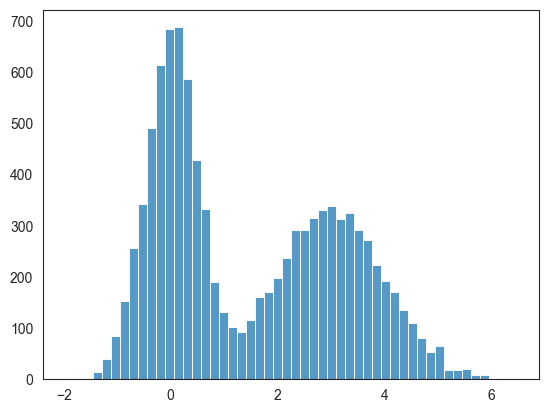

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline


ax = sns.histplot(gt_data, bins=50, kde=False);
ax.set_ylabel("");

In [4]:
num_iter = 500

def run_one_experiment(data):
    pred_gmm = Mixture.new_random([-1.0, 4.0], [0.001, 2.0], [2.5, 10.0], [0.001, 5.0])
    for i in range(num_iter):
        gamma0, likelihood = pred_gmm.e_step(data)
        pred_gmm.m_step(data, gamma0)
    return pred_gmm, likelihood

In [5]:
num_randomizations = 50

best_mixture = None
max_likelihood = float('-inf')
for i in range(num_randomizations):
    pred_gmm, likelihood = run_one_experiment(gt_data)
    if likelihood > max_likelihood:
        max_likelihood = likelihood
        best_mixture = pred_gmm

print(f'Best --- {best_mixture}', f'(likelihood={max_likelihood})')
print(f'Ground Truth --- {gmm}')

Best --- Mixture: Gaussian(μ=0.031, σ=0.483), Gaussian(μ=3.078, σ=0.768), pi=0.515 (likelihood=2280.6094921022764)
Ground Truth --- Mixture: Gaussian(μ=0.0, σ=0.5), Gaussian(μ=3.0, σ=1.0), pi=0.5


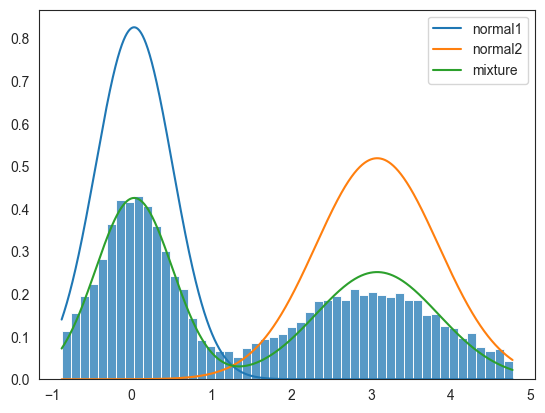

In [6]:
_, ax = plt.subplots(1, 1)

p1 = np.percentile(gt_data, 2)
p2 = np.percentile(gt_data, 98)
gt_data = gt_data[gt_data > p1]
gt_data = gt_data[gt_data < p2]

sns.histplot(x=gt_data, stat="density", bins=50, ax=ax);
ax.set_ylabel("");

x = np.linspace(gt_data.min(), gt_data.max(), 10000)
normal1 = best_mixture.normal1.pdf(x)
normal2 = best_mixture.normal2.pdf(x)
mixture = best_mixture.pdf(x)
ax.plot(x, normal1, label='normal1');
ax.plot(x, normal2, label='normal2');
ax.plot(x, mixture, label='mixture');

plt.legend();